In [32]:
import numpy as np
import skfuzzy as fuzz
import subprocess
import sys
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

In [33]:
#variable declaration.
soil_moisture = ctrl.Antecedent(np.arange(0, 101, 1), 'soil_moisture')
temperature = ctrl.Antecedent(np.arange(0, 41, 1), 'temperature')
watering_duration = ctrl.Consequent(np.arange(0, 31, 1), 'watering_duration')

#define membership function

# 1. Soil Moisture (0 - 100%)
# Use trapmf for the edges (Dry, Wet) and trimf for the middle (Medium)
soil_moisture['dry'] = fuzz.trapmf(soil_moisture.universe, [0, 0, 20, 40])
soil_moisture['medium'] = fuzz.trimf(soil_moisture.universe, [30, 50, 70])
soil_moisture['wet'] = fuzz.trapmf(soil_moisture.universe, [60, 80, 100, 100])

# 2. Temperature (0 - 40 degrees)
# Use trimf for all states
temperature['cold'] = fuzz.trimf(temperature.universe, [0, 0, 15])
temperature['warm'] = fuzz.trimf(temperature.universe, [10, 20, 30])
temperature['hot'] = fuzz.trimf(temperature.universe, [25, 40, 40])

# 3. Watering Duration (0 - 30 minutes)
# Use trimf for all states
watering_duration['short'] = fuzz.trimf(watering_duration.universe, [0, 0, 10])
watering_duration['medium'] = fuzz.trimf(watering_duration.universe, [5, 15, 25])
watering_duration['long'] = fuzz.trimf(watering_duration.universe, [20, 30, 30])



d:\Application_Files\Anaconda\envs\foml\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


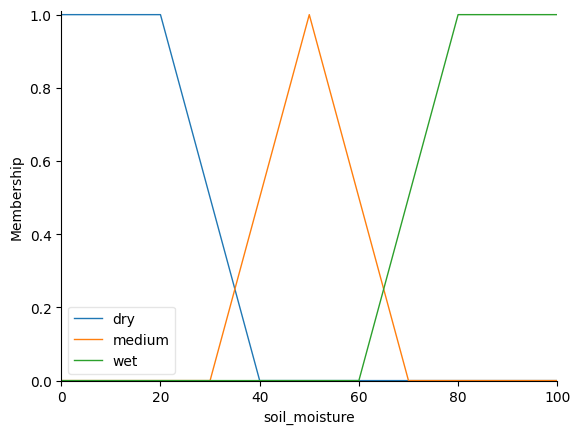

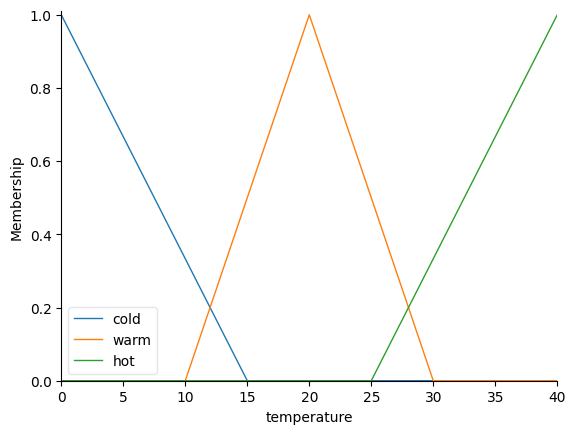

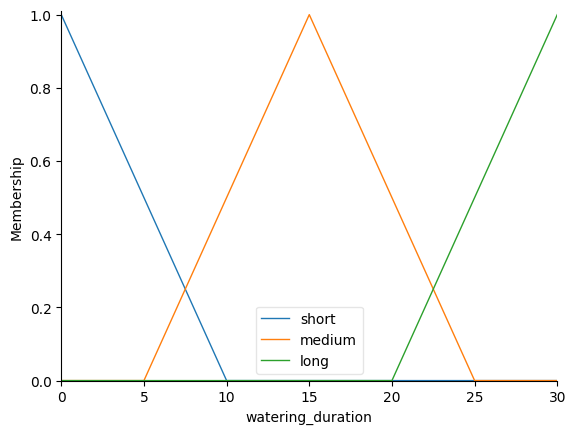

In [34]:
# Plot Membership Function

soil_moisture.view()
temperature.view()
watering_duration.view()

In [35]:
# 4. Define Fuzzy Rule

rule1 = ctrl.Rule(soil_moisture['dry'] & temperature['cold'],watering_duration['short'])
rule2 = ctrl.Rule(soil_moisture['dry'] & temperature['warm'],watering_duration['medium'])
rule3 = ctrl.Rule(soil_moisture['dry'] & temperature['hot'], watering_duration['long'])

rule4 = ctrl.Rule(soil_moisture['medium'] & temperature['cold'],watering_duration['short'])
rule5 = ctrl.Rule(soil_moisture['medium'] & temperature['warm'],watering_duration['medium'])
rule6 = ctrl.Rule(soil_moisture['medium'] & temperature['hot'], watering_duration['long'])

rule7 = ctrl.Rule(soil_moisture['wet'] & temperature['cold'],watering_duration['short'])
rule8 = ctrl.Rule(soil_moisture['wet'] & temperature['warm'],watering_duration['medium'])
rule9 = ctrl.Rule(soil_moisture['wet'] & temperature['hot'], watering_duration['long'])
rule10 = ctrl.Rule(soil_moisture['wet'] & temperature['hot'], watering_duration['long'])

Defuzzified water duration Output:25.78


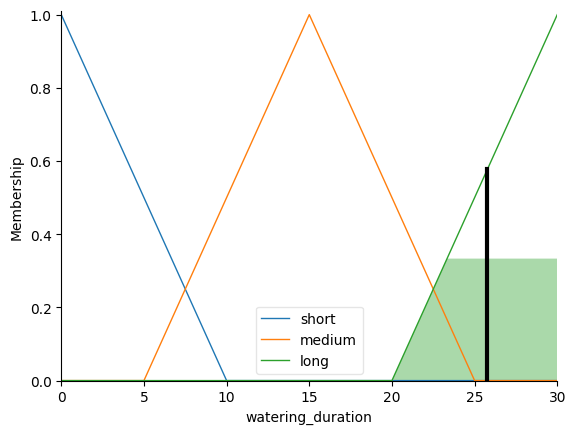

In [36]:
water_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
water_sim = ctrl.ControlSystemSimulation(water_ctrl)

water_sim.input['soil_moisture'] = 10
water_sim.input['temperature'] = 30

water_sim.compute()

print(f"Defuzzified water duration Output:{water_sim.output['watering_duration']:.2f}")

watering_duration.view(sim = water_sim)

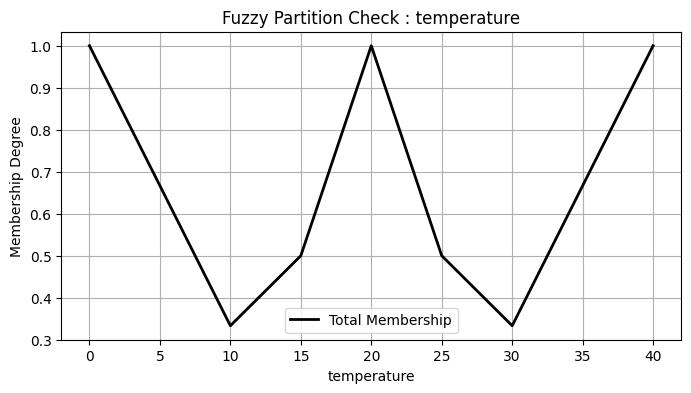

Correct temperature fuzzy partitioning.


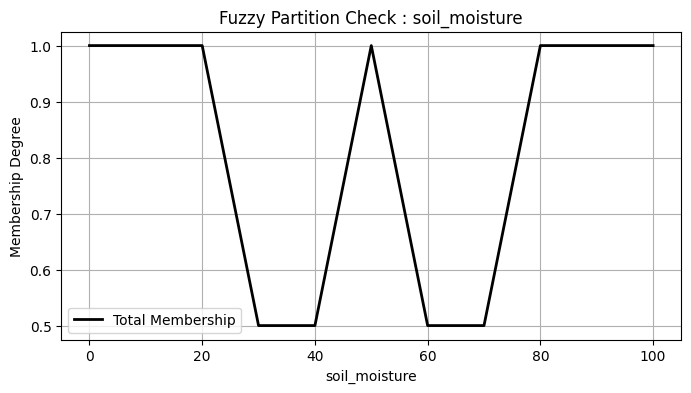

Correct soil_moisture fuzzy partitioning.


In [37]:
def check_partition(Variable, labels, universe):
    total_membership = np.zeros_like(universe, dtype=float)

    for label in labels:
        mf = Variable[label]
        total_membership += fuzz.interp_membership(Variable.universe, mf.mf, universe)
    
    plt.figure(figsize=(8, 4))
    plt.plot(universe, total_membership,'k', linewidth=2, label='Total Membership')
    plt.title(f'Fuzzy Partition Check : {Variable.label}')
    plt.xlabel(Variable.label)
    plt.ylabel('Membership Degree')
    plt.legend()
    plt.grid(True)
    plt.show()# Check fuzzy partition for soil_moisture

    uncovered = np.sum(total_membership == 0)
    if uncovered == 0:
        print(f"Correct {Variable.label} fuzzy partitioning.")
    else:
        print(f"Incorrect {Variable.label} fuzzy partitioning. Uncovered regions: {uncovered}")

temp_labels = np.arange(0, 41, 1)
check_partition(temperature, ['cold', 'warm', 'hot'], temp_labels)

temp_labels = np.arange(0, 101, 1)
check_partition(soil_moisture, ['dry', 'medium', 'wet'], temp_labels)

In [45]:
def check_rule_conflicts(rules):
    rule_data = []
    for i, rule in enumerate(rules):
        rule_data.append({
            'index': i + 1,
            'antecedent': str(rule.antecedent),
            'full_rule': str(rule)
        })

    conflicts = {}

    for i in range(len(rule_data)):
        for j in range(i + 1, len(rule_data)):
            rule_i = rule_data[i]
            rule_j = rule_data[j]

            if rule_i['antecedent'] == rule_j['antecedent']:
                antecedent = rule_i['antecedent']
                
                if antecedent not in conflicts:
                    conflicts[antecedent] = {
                        'redundancy': [],
                        'ambiguity': []
                    }

                if rule_i['full_rule'] == rule_j['full_rule']:
                    pair = tuple(sorted((rule_i['index'], rule_j['index'])))
                    if pair not in [p for r in conflicts[antecedent]['redundancy'] for p in r]:
                        conflicts[antecedent]['redundancy'].append((rule_i, rule_j))

                else:
                    pair = tuple(sorted((rule_i['index'], rule_j['index'])))
                    if pair not in [p for r in conflicts[antecedent]['ambiguity'] for p in r]:
                        conflicts[antecedent]['ambiguity'].append((rule_i, rule_j))


    if not conflicts:
        print("No rule conflict detected (based on identical antecedents).")
        return

    print("\n Rule Conflicts Detected ")
    
    conflict_found = False
    
    for antecedent, conflict_types in conflicts.items():
        if conflict_types['redundancy']:
            conflict_found = True
            print(f"\nConflicting Antecedent: {antecedent}")
            
            for r_pair in conflict_types['redundancy']:
                r1, r2 = r_pair
                print(f" -> Rules #{r1['index']} and #{r2['index']} are IDENTICAL.")
                print(f"    - Rule #{r1['index']} Text: {r1['full_rule']}")
                print(f"    - Rule #{r2['index']} Text: {r2['full_rule']}")
                
        if conflict_types['ambiguity']:
            conflict_found = True
            print(f"\n Conflicting Antecedent: {antecedent}")
            
            for r_pair in conflict_types['ambiguity']:
                r1, r2 = r_pair
                print(f" -> Rules #{r1['index']} and #{r2['index']} have the same antecedent but DIFFERENT consequents.")
                print(f"    - Rule #{r1['index']} Text: {r1['full_rule']}")
                print(f"    - Rule #{r2['index']} Text: {r2['full_rule']}")

    if not conflict_found:
         print("No rule conflict detected (based on identical antecedents).")



In [46]:
rules = [rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10]
check_rule_conflicts(rules)


 Rule Conflicts Detected 

Conflicting Antecedent: soil_moisture[wet] AND temperature[hot]
 -> Rules #9 and #10 are IDENTICAL.
    - Rule #9 Text: IF soil_moisture[wet] AND temperature[hot] THEN watering_duration[long]
	AND aggregation function : fmin
	OR aggregation function  : fmax
    - Rule #10 Text: IF soil_moisture[wet] AND temperature[hot] THEN watering_duration[long]
	AND aggregation function : fmin
	OR aggregation function  : fmax


Soil Moisture - (0-100%)
Temperature - (0- 40)
Watering duration - (0 - 30 min)